# MOVIES MOVIES MOVIES !!!

In [7]:
import requests
import tarfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from sklearn.linear_model import LinearRegression
from statsmodels.formula import api as stats
from sklearn.preprocessing import PolynomialFeatures
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8');

'en_US.UTF-8'

## Step 1: Data Collection

In [10]:
# downloading the data. These are datasets provided for non-commercial use
url= 'https://datasets.imdbws.com/title.basics.tsv.gz';
url2= 'https://datasets.imdbws.com/title.ratings.tsv.gz';

titledata= requests.get(url);
ratingdata= requests.get(url2);

title_filename= 'title_data.tsv.gz';
ratings_filename= 'ratings.tsv.gz';

# write the files to our directory
open(title_filename, 'wb').write(titledata.content);
open(ratings_filename, 'wb').write(ratingdata.content);

In [12]:
# reading the data into panda dataframes
title_df= pd.read_csv('title_data.tsv.gz', sep="\t", dtype={'isAdult': str});
ratings_df= pd.read_csv('ratings.tsv.gz', sep="\t");
print(title_df.head(5), ratings_df.head(5))

      tconst titleType            primaryTitle           originalTitle  \
0  tt0000001     short              Carmencita              Carmencita   
1  tt0000002     short  Le clown et ses chiens  Le clown et ses chiens   
2  tt0000003     short          Pauvre Pierrot          Pauvre Pierrot   
3  tt0000004     short             Un bon bock             Un bon bock   
4  tt0000005     short        Blacksmith Scene        Blacksmith Scene   

  isAdult startYear endYear runtimeMinutes                    genres  
0       0      1894      \N              1         Documentary,Short  
1       0      1892      \N              5           Animation,Short  
2       0      1892      \N              4  Animation,Comedy,Romance  
3       0      1892      \N             12           Animation,Short  
4       0      1893      \N              1              Comedy,Short         tconst  averageRating  numVotes
0  tt0000001            5.7      1971
1  tt0000002            5.8       263
2  tt0000003   

## Step 2: Data Processing

Merge our two datasets into the same datafram

In [13]:
# when u remove and clean values
df = pd.merge(left=title_df, right=ratings_df, on='tconst', how='inner')

In [14]:
df.drop(labels=['endYear'],axis=1, inplace=True)

In [15]:
df.head(5)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000001,short,Carmencita,Carmencita,0,1894,1,"Documentary,Short",5.7,1971
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,5,"Animation,Short",5.8,263
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,4,"Animation,Comedy,Romance",6.5,1817
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,12,"Animation,Short",5.6,178
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,1,"Comedy,Short",6.2,2613


Keep only the titles named movies

We need to parse certain columns to integers

In [16]:
df.dtypes

tconst             object
titleType          object
primaryTitle       object
originalTitle      object
isAdult            object
startYear          object
runtimeMinutes     object
genres             object
averageRating     float64
numVotes            int64
dtype: object

Here we are only looking at movies so we can drop all other forms of media (short films, shows, ...). We are analyzing these movies over time thus, we can drop any movies without a release date ('startYear'). Then, we need to convert the release dates from strings to integers so we can plot them.

In [17]:
# keep only movies
df = df[df['titleType'] == 'movie']
# drop movies without a release date
df = df[df['startYear'] != '\\N']
# convert release date from strings to integers
df['startYear'] = df['startYear'].apply(int)

In [18]:
to_number = lambda x: float(x) if x.isdigit() else np.nan
df['runtimeMinutes'] = df['runtimeMinutes'].apply(to_number)

In [19]:
#move this to data collection section
# original url with no offset on 
box_office_url = 'https://www.boxofficemojo.com/chart/ww_top_lifetime_gross/?offset='
box_office_df = pd.DataFrame()
# iterate over each webpage 200 ranks at a time
for i in range(0,1000,200):
    # append the offset to the url
    box_req = requests.get(box_office_url + str(i))
    soup = BeautifulSoup(box_req.content, 'html.parser')
    # add the next 200 ranks to the current 
    box_office_df = pd.concat([box_office_df, pd.read_html(io=str(soup.find('table')))[0]])
box_office_df.head(10)

,Rank,Title,Worldwide Lifetime Gross,Domestic Lifetime Gross,Domestic %,Foreign Lifetime Gross,Foreign %,Year
0,1,Avatar,"$2,923,706,026","$785,221,649",26.9%,"$2,138,484,377",73.1%,2009
1,2,Avengers: Endgame,"$2,799,439,100","$858,373,000",30.7%,"$1,941,066,100",69.3%,2019
2,3,Avatar: The Way of Water,"$2,319,770,231","$684,020,678",29.5%,"$1,635,749,553",70.5%,2022
3,4,Titanic,"$2,264,743,257","$674,292,608",29.8%,"$1,590,450,649",70.2%,1997
4,5,Star Wars: Episode VII - The Force Awakens,"$2,071,310,218","$936,662,225",45.2%,"$1,134,647,993",54.8%,2015
5,6,Avengers: Infinity War,"$2,052,415,039","$678,815,482",33.1%,"$1,373,599,557",66.9%,2018
6,7,Spider-Man: No Way Home,"$1,921,847,111","$814,115,070",42.4%,"$1,107,732,041",57.6%,2021
7,8,Jurassic World,"$1,671,537,444","$653,406,625",39.1%,"$1,018,130,819",60.9%,2015
8,9,The Lion King,"$1,663,075,401","$543,638,043",32.7%,"$1,119,437,358",67.3%,2019
9,10,The Avengers,"$1,520,538,536","$623,357,910",41%,"$897,180,626",59%,2012


Rename the 'Title' column to 'primaryTitle' to merge with the original dataframe

In [20]:
box_office_df.rename(columns={'Title': 'primaryTitle'},inplace=True)

Something about bias here...

In [21]:
# 1 if isAdult else, if it's any other value (0 or invalid)
# TODO comment on how this will introduce bias
function = lambda x: True if x == '1' else False
df['isAdult'] = df['isAdult'].apply(function)

In [22]:

df.head(5)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes
8,tt0000009,movie,Miss Jerry,Miss Jerry,False,1894,45.0,Romance,5.3,204
144,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,False,1897,100.0,"Documentary,News,Sport",5.3,469
326,tt0000502,movie,Bohemios,Bohemios,False,1905,100.0,\N,4.1,15
358,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,False,1906,70.0,"Action,Adventure,Biography",6.0,826
366,tt0000591,movie,The Prodigal Son,L'enfant prodigue,False,1907,90.0,Drama,4.4,20


## Step 3: Exploratory Analysis and Data Vizualization

### Amount of movies

Let's look at how many movies were produced every year. Then we can plot it as a histogram with each bin counting 5 years worth of data.

(array([4.0000e+00, 9.0000e+00, 4.5000e+01, 2.9500e+02, 1.2290e+03,
        1.4880e+03, 2.0050e+03, 3.3950e+03, 4.9950e+03, 4.9030e+03,
        4.0460e+03, 5.5450e+03, 6.6400e+03, 7.4880e+03, 8.7680e+03,
        1.0979e+04, 1.0963e+04, 1.1721e+04, 1.2835e+04, 1.2713e+04,
        1.3397e+04, 1.7296e+04, 2.5548e+04, 3.8394e+04, 5.8730e+04]),
 array([1894., 1899., 1904., 1909., 1914., 1919., 1924., 1929., 1934.,
        1939., 1944., 1949., 1954., 1959., 1964., 1969., 1974., 1979.,
        1984., 1989., 1994., 1999., 2004., 2009., 2014., 2019.]),
 <BarContainer object of 25 artists>)

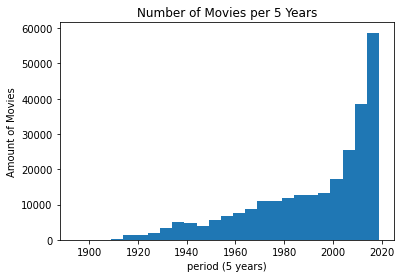

In [23]:
# count of movies for each year
years = df['startYear']
# create bins of size 5 starting 
bins = np.arange(start=df['startYear'].min(),stop=df['startYear'].max(),step=5)
plt.xlabel('period (5 years)')
plt.ylabel('Amount of Movies')
plt.title(label='Number of Movies per 5 Years')
plt.hist(x=years,bins=bins)

Observe as time progressed more and more movies were created. From the late 1800s to the late 1910s the camera and filming technology was very limited making it difficult to produce movies. Then, as the technology to film and store movies became more advance the demand to watch those movies also grew causing more to be produced. 

### Runtime

Next, let's look at the runtimes of movies over the years.

In [24]:
by_year = df.dropna(axis=0,subset='runtimeMinutes').groupby(by='startYear')

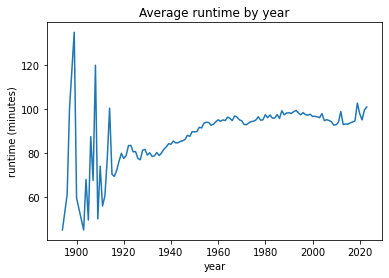

In [25]:
avgs = by_year['runtimeMinutes'].mean()
plt.xlabel('year')
plt.ylabel('runtime (minutes)')
plt.title('Average runtime by year')
plt.plot(avgs)

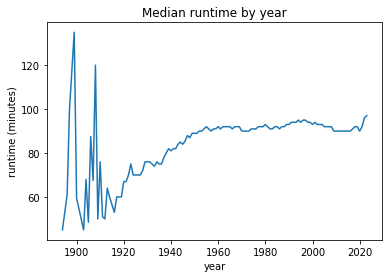

In [26]:
plt.xlabel('year')
plt.ylabel('runtime (minutes)')
plt.title('Median runtime by year')
plt.plot(by_year['runtimeMinutes'].median())

The average and median runtimes of movies has almost an upwards trend then, flattened out to about 90 minutes. In the early 20th century, there were barely any movies thus, it was much more sensitive to outliers. Then, as more movies were produced, the runtime stabilized and followed a trend over the years.

### Box office

In [27]:
boxdf = df[['primaryTitle', 'genres', 'averageRating', 'numVotes', 'runtimeMinutes']].merge(box_office_df, how='right', on='primaryTitle')

In [28]:
boxdf = boxdf.sort_values('numVotes', ascending=False).drop_duplicates('primaryTitle').sort_values(by='Rank')

In [29]:
boxdf.head(10)

,primaryTitle,genres,averageRating,numVotes,runtimeMinutes,Rank,Worldwide Lifetime Gross,Domestic Lifetime Gross,Domestic %,Foreign Lifetime Gross,Foreign %,Year
2,Avatar,"Action,Adventure,Fantasy",7.9,1339903,162.0,1,"$2,923,706,026","$785,221,649",26.9%,"$2,138,484,377",73.1%,2009
4,Avengers: Endgame,"Action,Adventure,Drama",8.4,1174213,181.0,2,"$2,799,439,100","$858,373,000",30.7%,"$1,941,066,100",69.3%,2019
5,Avatar: The Way of Water,"Action,Adventure,Fantasy",7.7,375367,192.0,3,"$2,319,770,231","$684,020,678",29.5%,"$1,635,749,553",70.5%,2022
8,Titanic,"Drama,Romance",7.9,1216748,194.0,4,"$2,264,743,257","$674,292,608",29.8%,"$1,590,450,649",70.2%,1997
12,Star Wars: Episode VII - The Force Awakens,"Action,Adventure,Sci-Fi",7.8,945729,138.0,5,"$2,071,310,218","$936,662,225",45.2%,"$1,134,647,993",54.8%,2015
13,Avengers: Infinity War,"Action,Adventure,Sci-Fi",8.4,1118036,149.0,6,"$2,052,415,039","$678,815,482",33.1%,"$1,373,599,557",66.9%,2018
14,Spider-Man: No Way Home,"Action,Adventure,Fantasy",8.2,791714,148.0,7,"$1,921,847,111","$814,115,070",42.4%,"$1,107,732,041",57.6%,2021
15,Jurassic World,"Action,Adventure,Sci-Fi",6.9,655694,124.0,8,"$1,671,537,444","$653,406,625",39.1%,"$1,018,130,819",60.9%,2015
22,The Avengers,"Action,Sci-Fi",8.0,1412998,143.0,10,"$1,520,538,536","$623,357,910",41%,"$897,180,626",59%,2012
23,Furious 7,"Action,Crime,Thriller",7.1,398085,137.0,11,"$1,515,341,399","$353,007,020",23.3%,"$1,162,334,379",76.7%,2015


In [30]:
locale.atof('$1,234,567'.strip('$'))

1234567.0

In [31]:
convert = lambda x: locale.atof(x.strip('$')) if x != '-' else np.nan
boxdf['Worldwide Lifetime Gross'] = boxdf['Worldwide Lifetime Gross'].apply(convert)
boxdf['Domestic Lifetime Gross'] = boxdf['Domestic Lifetime Gross'].apply(convert)
boxdf['Foreign Lifetime Gross'] = boxdf['Foreign Lifetime Gross'].apply(convert)

In [32]:
boxdf.head(10)

,primaryTitle,genres,averageRating,numVotes,runtimeMinutes,Rank,Worldwide Lifetime Gross,Domestic Lifetime Gross,Domestic %,Foreign Lifetime Gross,Foreign %,Year
2,Avatar,"Action,Adventure,Fantasy",7.9,1339903,162.0,1,2.923706e+09,785221649.0,26.9%,2.138484e+09,73.1%,2009
4,Avengers: Endgame,"Action,Adventure,Drama",8.4,1174213,181.0,2,2.799439e+09,858373000.0,30.7%,1.941066e+09,69.3%,2019
5,Avatar: The Way of Water,"Action,Adventure,Fantasy",7.7,375367,192.0,3,2.319770e+09,684020678.0,29.5%,1.635750e+09,70.5%,2022
8,Titanic,"Drama,Romance",7.9,1216748,194.0,4,2.264743e+09,674292608.0,29.8%,1.590451e+09,70.2%,1997
12,Star Wars: Episode VII - The Force Awakens,"Action,Adventure,Sci-Fi",7.8,945729,138.0,5,2.071310e+09,936662225.0,45.2%,1.134648e+09,54.8%,2015
13,Avengers: Infinity War,"Action,Adventure,Sci-Fi",8.4,1118036,149.0,6,2.052415e+09,678815482.0,33.1%,1.373600e+09,66.9%,2018
14,Spider-Man: No Way Home,"Action,Adventure,Fantasy",8.2,791714,148.0,7,1.921847e+09,814115070.0,42.4%,1.107732e+09,57.6%,2021
15,Jurassic World,"Action,Adventure,Sci-Fi",6.9,655694,124.0,8,1.671537e+09,653406625.0,39.1%,1.018131e+09,60.9%,2015
22,The Avengers,"Action,Sci-Fi",8.0,1412998,143.0,10,1.520539e+09,623357910.0,41%,8.971806e+08,59%,2012
23,Furious 7,"Action,Crime,Thriller",7.1,398085,137.0,11,1.515341e+09,353007020.0,23.3%,1.162334e+09,76.7%,2015


<Axes: xlabel='averageRating', ylabel='Worldwide Lifetime Gross'>

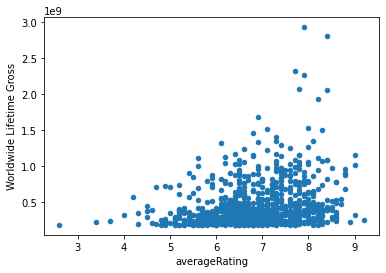

In [33]:
boxdf.plot.scatter(x='averageRating', y='Worldwide Lifetime Gross')

<Axes: xlabel='numVotes', ylabel='Worldwide Lifetime Gross'>

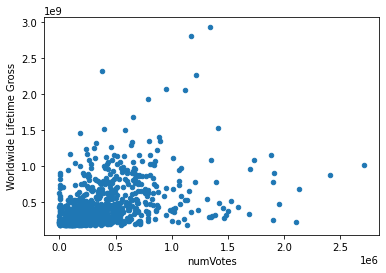

In [34]:
boxdf.plot.scatter(x='numVotes', y='Worldwide Lifetime Gross')

<Axes: xlabel='runtimeMinutes', ylabel='Worldwide Lifetime Gross'>

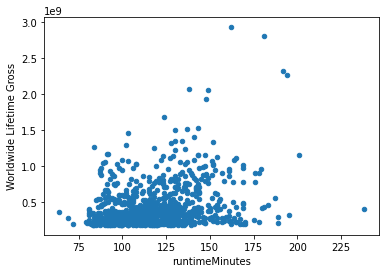

In [35]:
boxdf.plot.scatter(x='runtimeMinutes', y='Worldwide Lifetime Gross')

## Step 4: Analysis, Hypothesis Testing, and Machine Learning

In [36]:
boxdf = boxdf.dropna(how='all',subset='numVotes')

Let's try normalizing the residuals.

<Axes: title={'center': 'Ratings for Top 1000 Box Office'}, xlabel='averageRating', ylabel='Worldwide Lifetime Gross'>

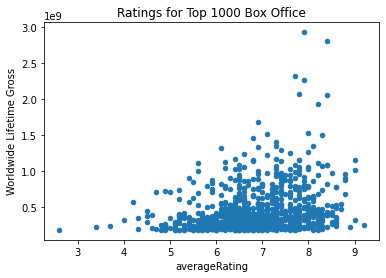

In [37]:
boxdf.plot.scatter(x='averageRating',y='Worldwide Lifetime Gross', title='Ratings for Top 1000 Box Office')

In [98]:
boxdf = boxdf.rename(columns={'Worldwide Lifetime Gross': 'boxOffice'})
thousand = df[df['numVotes'] > 400000].copy()

Let's try to compare how the number of votes on a movie impacts its average rating.

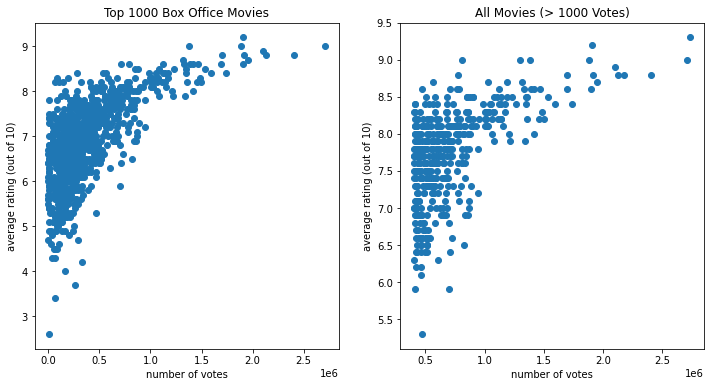

In [99]:
figure, (axis1, axis2) = plt.subplots(1,2)

# plot the top 1000 box office movies
axis1.set_xlabel('number of votes')
axis1.set_ylabel('average rating (out of 10)')
axis1.set_title('Top 1000 Box Office Movies')
axis1.scatter(boxdf['numVotes'], boxdf['averageRating'])

# plot all movies
axis2.set_xlabel('number of votes')
axis2.set_ylabel('average rating (out of 10)')
axis2.set_title('All Movies (> 1000 Votes)')
axis2.scatter(thousand['numVotes'], thousand['averageRating'])

figure.set_size_inches(12,6)
plt.show()

Let's test how a linear regression model will perform. We want to predict the average rating based on the numbe of votes.

In [100]:
lin_model = stats.ols(formula='averageRating ~ numVotes', data=thousand).fit()

We can now plot the results. It seems this model is inaccurate as the residuals are not normally distributed 

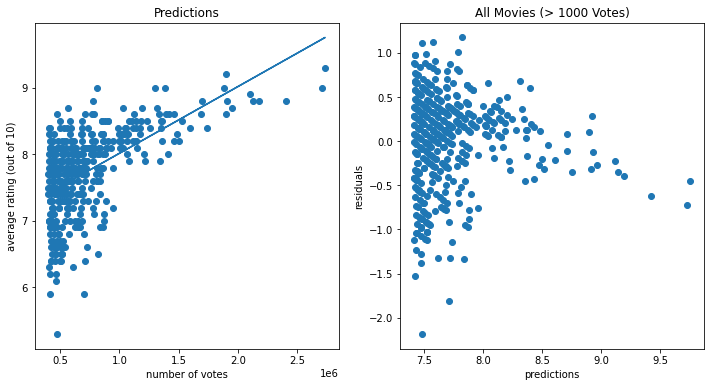

In [101]:
votes = thousand['numVotes']
preds = lin_model.predict(votes)

figure, (axis1, axis2) = plt.subplots(1,2)

# plot the number of votes vs rating with the linear regression model
axis1.set_xlabel('number of votes')
axis1.set_ylabel('average rating (out of 10)')
axis1.set_title('Predictions')
axis1.scatter(x=votes, y=thousand['averageRating'])
axis1.plot(votes, lin_model.predict(votes))

# plot all movies
axis2.set_xlabel('predictions')
axis2.set_ylabel('residuals')
axis2.set_title('All Movies (> 1000 Votes)')
axis2.scatter(x=preds, y=lin_model.resid)

figure.set_size_inches(12,6)
plt.show()

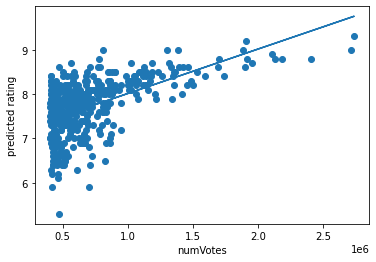

In [102]:
votes = thousand['numVotes']
preds = lin_model.predict(votes)
plt.scatter(votes,thousand['averageRating'])
plt.xlabel('numVotes')
plt.ylabel('predicted rating')
plt.plot(votes,lin_model.predict(votes))

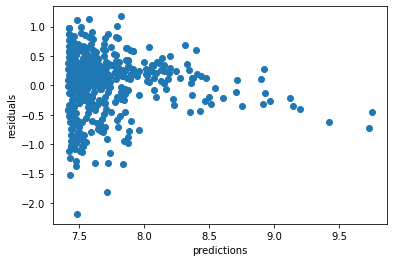

In [103]:
plt.xlabel('predictions')
plt.ylabel('residuals')
plt.scatter(preds, lin_model.resid)

Let's take a log transform of the average rating

In [104]:
thousand['logRating'] = thousand['averageRating'].apply(np.exp)

In [105]:
log_model = stats.ols(formula='logRating ~ numVotes',data=thousand).fit()

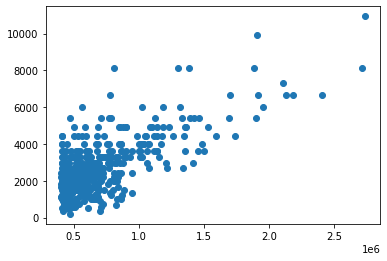

In [106]:
plt.scatter(votes,thousand['logRating'])

In [115]:
thousand.size

4763

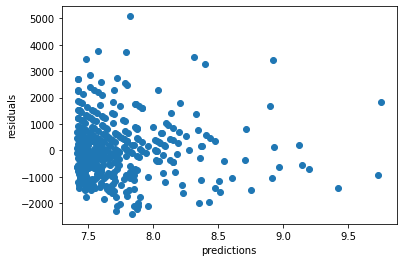

In [107]:
log_preds = log_model.predict(votes)
plt.xlabel('predictions')
plt.ylabel('residuals')
plt.scatter(preds, log_model.resid)

(array([ 16.,  83., 108., 117.,  57.,  29.,  15.,   5.,   2.,   1.]),
 array([-2401.26595413, -1653.49687894,  -905.72780375,  -157.95872855,
          589.81034664,  1337.57942183,  2085.34849702,  2833.11757222,
         3580.88664741,  4328.6557226 ,  5076.42479779]),
 <BarContainer object of 10 artists>)

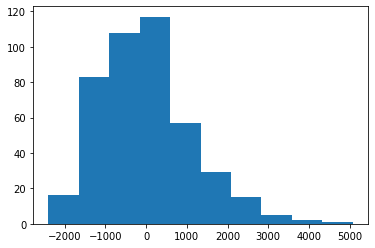

In [108]:
plt.hist(log_model.resid)

In [109]:
'''
k = df.size
for i,row in df.iterrows():
    if row['genres'] != '\\N':
        genres = row['genres'].split(',')
        df.loc[i,'genres'] = genres[0]
        for g in range(1,len(genres)):
            row['genres'] = genres[g]
            df.loc[k] = row
            k += 1
            
df.head(1)
'''

"\nk = df.size\nfor i,row in df.iterrows():\n    if row['genres'] != '\\N':\n        genres = row['genres'].split(',')\n        df.loc[i,'genres'] = genres[0]\n        for g in range(1,len(genres)):\n            row['genres'] = genres[g]\n            df.loc[k] = row\n            k += 1\n            \ndf.head(1)\n"

## Step 4: Analysis, Hypothesis Testing, and Machine Learning

In [110]:
# more in depth, test hypotheses coming from the graphs

## Step 5: Insight and Policy Decision

## Conclusion